In [3]:
# Importar librerías necesarias
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, applications, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

# Configuración de GPU
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("🔧 GPU configurada correctamente")
else:
    print("🔧 Usando CPU")

# Seeds para reproducibilidad
tf.random.set_seed(42)
np.random.seed(42)

print("✅ Entorno TensorFlow/Keras configurado correctamente")

🔧 GPU configurada correctamente
✅ Entorno TensorFlow/Keras configurado correctamente


In [4]:
# === PREPARAR DATASET CIFAR-10 ===

print("📊 PREPARANDO DATASET CIFAR-10")
print("-" * 50)

# 1. Cargar dataset CIFAR-10
(x_train_raw, y_train), (x_test_raw, y_test) = keras.datasets.cifar10.load_data()

# 2. Normalizar imágenes para CNN simple (0-255 -> 0-1)
# ⚠️ IMPORTANTE: Para transfer learning, usaremos preprocesamiento específico de cada modelo
x_train = x_train_raw.astype('float32') / 255.0
x_test = x_test_raw.astype('float32') / 255.0

# 3. Convertir labels a categorical (one-hot encoding)
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# 4. Definir nombres de clases
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

print("📊 INFORMACIÓN DEL DATASET:")
print(f"   📈 Entrenamiento: {x_train.shape[0]} imágenes")
print(f"   🧪 Test: {x_test.shape[0]} imágenes")
print(f"   📐 Dimensiones: {x_train.shape[1:]} (HxWxC)")
print(f"   📋 Clases: {num_classes}")

# 5. Configurar batch size para entrenamiento
batch_size = 128
print(f"   📦 Batch size: {batch_size}")

📊 PREPARANDO DATASET CIFAR-10
--------------------------------------------------
📊 INFORMACIÓN DEL DATASET:
   📈 Entrenamiento: 50000 imágenes
   🧪 Test: 10000 imágenes
   📐 Dimensiones: (32, 32, 3) (HxWxC)
   📋 Clases: 10
   📦 Batch size: 128


In [5]:
# === PREPROCESAMIENTO PARA TRANSFER LEARNING ===

print("⚠️ CORRECCIÓN CRÍTICA: Preprocesamiento Específico")
print("-" * 50)
print("📌 Cada arquitectura pre-entrenada requiere su propio preprocesamiento!")
print("   - MobileNetV2 espera: [-1, 1]")
print()

# Preprocesar imágenes específicamente para MobileNetV2
x_train_mobilenet = applications.mobilenet_v2.preprocess_input(x_train_raw.copy().astype('float32'))
x_test_mobilenet = applications.mobilenet_v2.preprocess_input(x_test_raw.copy().astype('float32'))

print("✅ Datos preprocesados correctamente para MobileNetV2")
print(f"   📊 Rango original: [0, 255]")
print(f"   📊 Después de preprocesamiento: [{x_train_mobilenet.min():.2f}, {x_train_mobilenet.max():.2f}]")


⚠️ CORRECCIÓN CRÍTICA: Preprocesamiento Específico
--------------------------------------------------
📌 Cada arquitectura pre-entrenada requiere su propio preprocesamiento!
   - MobileNetV2 espera: [-1, 1]

✅ Datos preprocesados correctamente para MobileNetV2
   📊 Rango original: [0, 255]
   📊 Después de preprocesamiento: [-1.00, 1.00]


In [6]:
# === CNN SIMPLE DESDE CERO ===

print("🏗️ IMPLEMENTANDO CNN SIMPLE")
print("-" * 50)

def create_simple_cnn(input_shape=(32, 32, 3), num_classes=10):
    model = keras.Sequential([
        # Bloque convolucional 1
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Bloque convolucional 2
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.Activation('relu'),
        layers.MaxPooling2D((2, 2)),

        # Clasificador
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Crear modelo CNN simple
simple_cnn = create_simple_cnn()

# Compilar modelo
simple_cnn.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # optimizador popular
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar arquitectura
simple_cnn.summary()

# Contar parámetros
total_params = simple_cnn.count_params()
print(f"🏗️ MODELO CNN SIMPLE:")
print(f"   🔢 Parámetros: {total_params:,}")

🏗️ IMPLEMENTANDO CNN SIMPLE
--------------------------------------------------


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,122,186 (8.10 MB)

 Trainable params: 2,122,186 (8.10 MB)

 Non-trainable params: 0 (0.00 B)

🏗️ MODELO CNN SIMPLE:
   🔢 Parámetros: 2,122,186


In [7]:
# === TRANSFER LEARNING CON KERAS APPLICATIONS ===

print("🎯 IMPLEMENTANDO TRANSFER LEARNING")
print("-" * 50)

# 1. Crear modelo con transfer learning
def create_transfer_model(input_shape=(32, 32, 3), num_classes=10):
    base_model = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    # Congelar capas del modelo base
    base_model.trainable = False

    # Crear modelo completo
    model = keras.Sequential([
        base_model,
        layers.Flatten(),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# 2. Crear modelo
transfer_model = create_transfer_model()

# Compilar modelo con learning rate más bajo para transfer learning
transfer_model.compile(
    optimizer=optimizers.Adam(learning_rate=0.001),  # LR más bajo para transfer learning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Mostrar arquitectura
transfer_model.summary()

# Contar parámetros
total_params = transfer_model.count_params()
trainable_params = sum([tf.keras.backend.count_params(w) for w in transfer_model.trainable_weights])

print("🎯 MODELO CON TRANSFER LEARNING:")
print(f"   🔢 Parámetros totales: {total_params:,}")
print(f"   🔓 Parámetros entrenables: {trainable_params:,}")

🎯 IMPLEMENTANDO TRANSFER LEARNING
--------------------------------------------------


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1, 1, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        12,810 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,270,794 (8.66 MB)

 Trainable params: 12,810 (50.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

🎯 MODELO CON TRANSFER LEARNING:
   🔢 Parámetros totales: 2,270,794
   🔓 Parámetros entrenables: 12,810


In [8]:
# 3. Configurar fine-tuning
def setup_fine_tuning(model, unfreeze_layers=10):
    # Descongelar las últimas capas del modelo base
    base_model = model.layers[0]
    base_model.trainable = True

    # Congelar todas las capas excepto las últimas N
    for layer in base_model.layers[:-unfreeze_layers]:
        layer.trainable = False

    # Recompilar con learning rate más bajo
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.0001),  # LR más bajo para fine-tuning
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    trainable = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    print(f"🔓 Fine-tuning configurado - Parámetros entrenables: {trainable:,}")

    return model

# Configurar fine-tuning (opcional)
transfer_model = setup_fine_tuning(transfer_model, unfreeze_layers=10)

🔓 Fine-tuning configurado - Parámetros entrenables: 745,290


In [9]:
# === ENTRENAMIENTO DE MODELOS ===

print("🏋️ CONFIGURANDO ENTRENAMIENTO")
print("-" * 50)

# Configurar callbacks
callbacks_list = [
    callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True
    )
]

# Entrenar CNN simple
print("🏗️ ENTRENANDO CNN SIMPLE...")
simple_history = simple_cnn.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=callbacks_list,
    verbose=1
)

print("\n🎯 ENTRENANDO TRANSFER LEARNING...")
transfer_history = transfer_model.fit(
    x_train, y_train,
    batch_size=batch_size,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=callbacks_list,
    verbose=1
)

# Extraer métricas de entrenamiento
simple_train_acc = simple_history.history['accuracy']
simple_test_acc = simple_history.history['val_accuracy']
transfer_train_acc = transfer_history.history['accuracy']
transfer_test_acc = transfer_history.history['val_accuracy']

🏋️ CONFIGURANDO ENTRENAMIENTO
--------------------------------------------------
🏗️ ENTRENANDO CNN SIMPLE...
Epoch 1/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.3832 - loss: 1.7051 - val_accuracy: 0.5991 - val_loss: 1.1417
Epoch 2/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.6099 - loss: 1.1121 - val_accuracy: 0.6512 - val_loss: 0.9995
Epoch 3/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.6727 - loss: 0.9378 - val_accuracy: 0.6767 - val_loss: 0.9345
Epoch 4/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7129 - loss: 0.8293 - val_accuracy: 0.6855 - val_loss: 0.9150
Epoch 5/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.7421 - loss: 0.7384 - val_accuracy: 0.6976 - val_loss: 0.8967
Epoch 6/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7746 - loss: 0.6525 - val_accuracy: 0.6886 - val_loss: 0.9435
Epoch 7/10
391/391 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.8031 - loss: 0.5704 - val_accuracy: 0.6790 - val_loss: 

📊 COMPARACIÓN VISUAL DEL PREPROCESAMIENTO
--------------------------------------------------


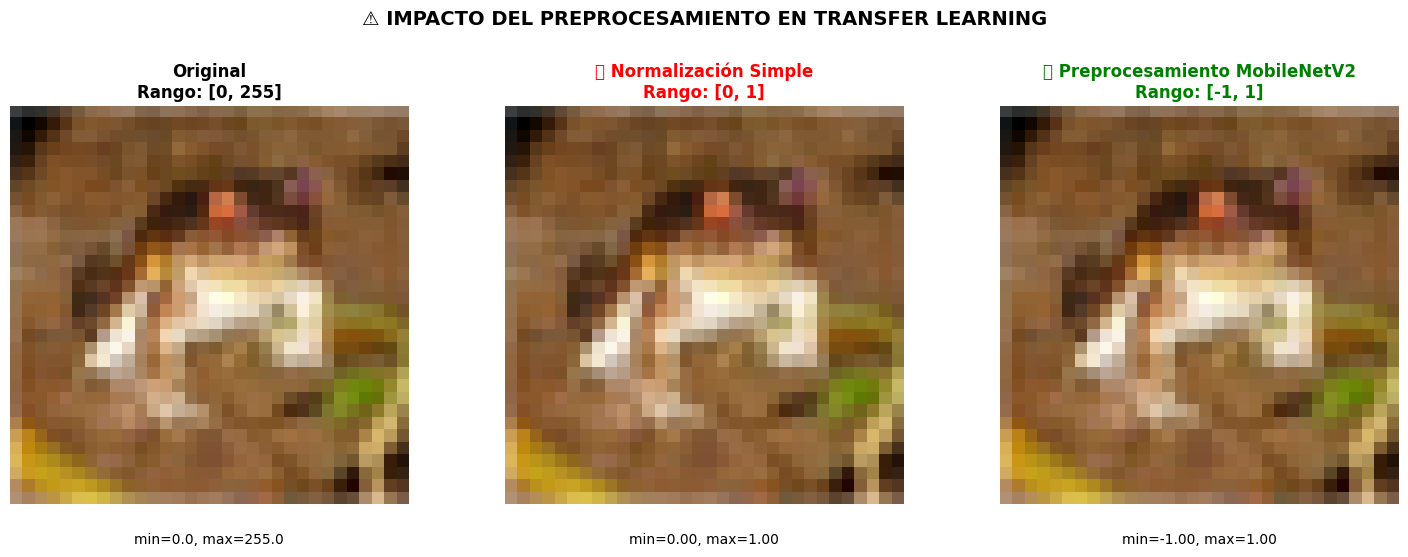


💡 CONCLUSIÓN:
   Si usamos la normalización simple [0,1] en lugar del preprocesamiento
   correcto de MobileNet [-1,1], el modelo verá datos DIFERENTES a los
   que vio durante su entrenamiento en ImageNet, resultando en:
   • Features incorrectos extraídos por las capas convolucionales
   • Peor performance y convergencia más lenta
   • Posible inestabilidad en el entrenamiento


In [10]:
# === VISUALIZACIÓN: Impacto del Preprocesamiento ===

print("📊 COMPARACIÓN VISUAL DEL PREPROCESAMIENTO")
print("-" * 50)

# Tomar una imagen de ejemplo
sample_image = x_train_raw[0]

# Aplicar diferentes tipos de preprocesamiento
img_original = sample_image  # [0, 255]
img_normalizada = sample_image / 255.0  # [0, 1]
img_mobilenet = applications.mobilenet_v2.preprocess_input(sample_image.copy().astype('float32'))  # [-1, 1]

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
axes[0].imshow(img_original.astype('uint8'))
axes[0].set_title('Original\nRango: [0, 255]', fontsize=12, fontweight='bold')
axes[0].axis('off')
axes[0].text(0.5, -0.1, f'min={img_original.min():.1f}, max={img_original.max():.1f}',
             ha='center', transform=axes[0].transAxes)

# Imagen normalizada (incorrecta para MobileNet)
axes[1].imshow(img_normalizada)
axes[1].set_title('❌ Normalización Simple\nRango: [0, 1]', fontsize=12, fontweight='bold', color='red')
axes[1].axis('off')
axes[1].text(0.5, -0.1, f'min={img_normalizada.min():.2f}, max={img_normalizada.max():.2f}',
             ha='center', transform=axes[1].transAxes)

# Imagen preprocesada correctamente para MobileNet
# Para visualizar, necesitamos reescalar a [0, 1]
img_mobilenet_vis = (img_mobilenet + 1) / 2.0  # de [-1,1] a [0,1] para visualización
axes[2].imshow(img_mobilenet_vis)
axes[2].set_title('✅ Preprocesamiento MobileNetV2\nRango: [-1, 1]',
                  fontsize=12, fontweight='bold', color='green')
axes[2].axis('off')
axes[2].text(0.5, -0.1, f'min={img_mobilenet.min():.2f}, max={img_mobilenet.max():.2f}',
             ha='center', transform=axes[2].transAxes)

plt.suptitle('⚠️ IMPACTO DEL PREPROCESAMIENTO EN TRANSFER LEARNING',
             fontsize=14, fontweight='bold', y=1.05)
plt.tight_layout()
plt.show()

print("\n💡 CONCLUSIÓN:")
print("   Si usamos la normalización simple [0,1] en lugar del preprocesamiento")
print("   correcto de MobileNet [-1,1], el modelo verá datos DIFERENTES a los")
print("   que vio durante su entrenamiento en ImageNet, resultando en:")
print("   • Features incorrectos extraídos por las capas convolucionales")
print("   • Peor performance y convergencia más lenta")
print("   • Posible inestabilidad en el entrenamiento")


📊 EVALUACIÓN FINAL
--------------------------------------------------
📊 COMPARACIÓN FINAL:
🏗️ CNN Simple: 0.6976 (69.76%)
🎯 Transfer Learning: 0.5555 (55.55%)
📈 Mejora: -14.21%
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step


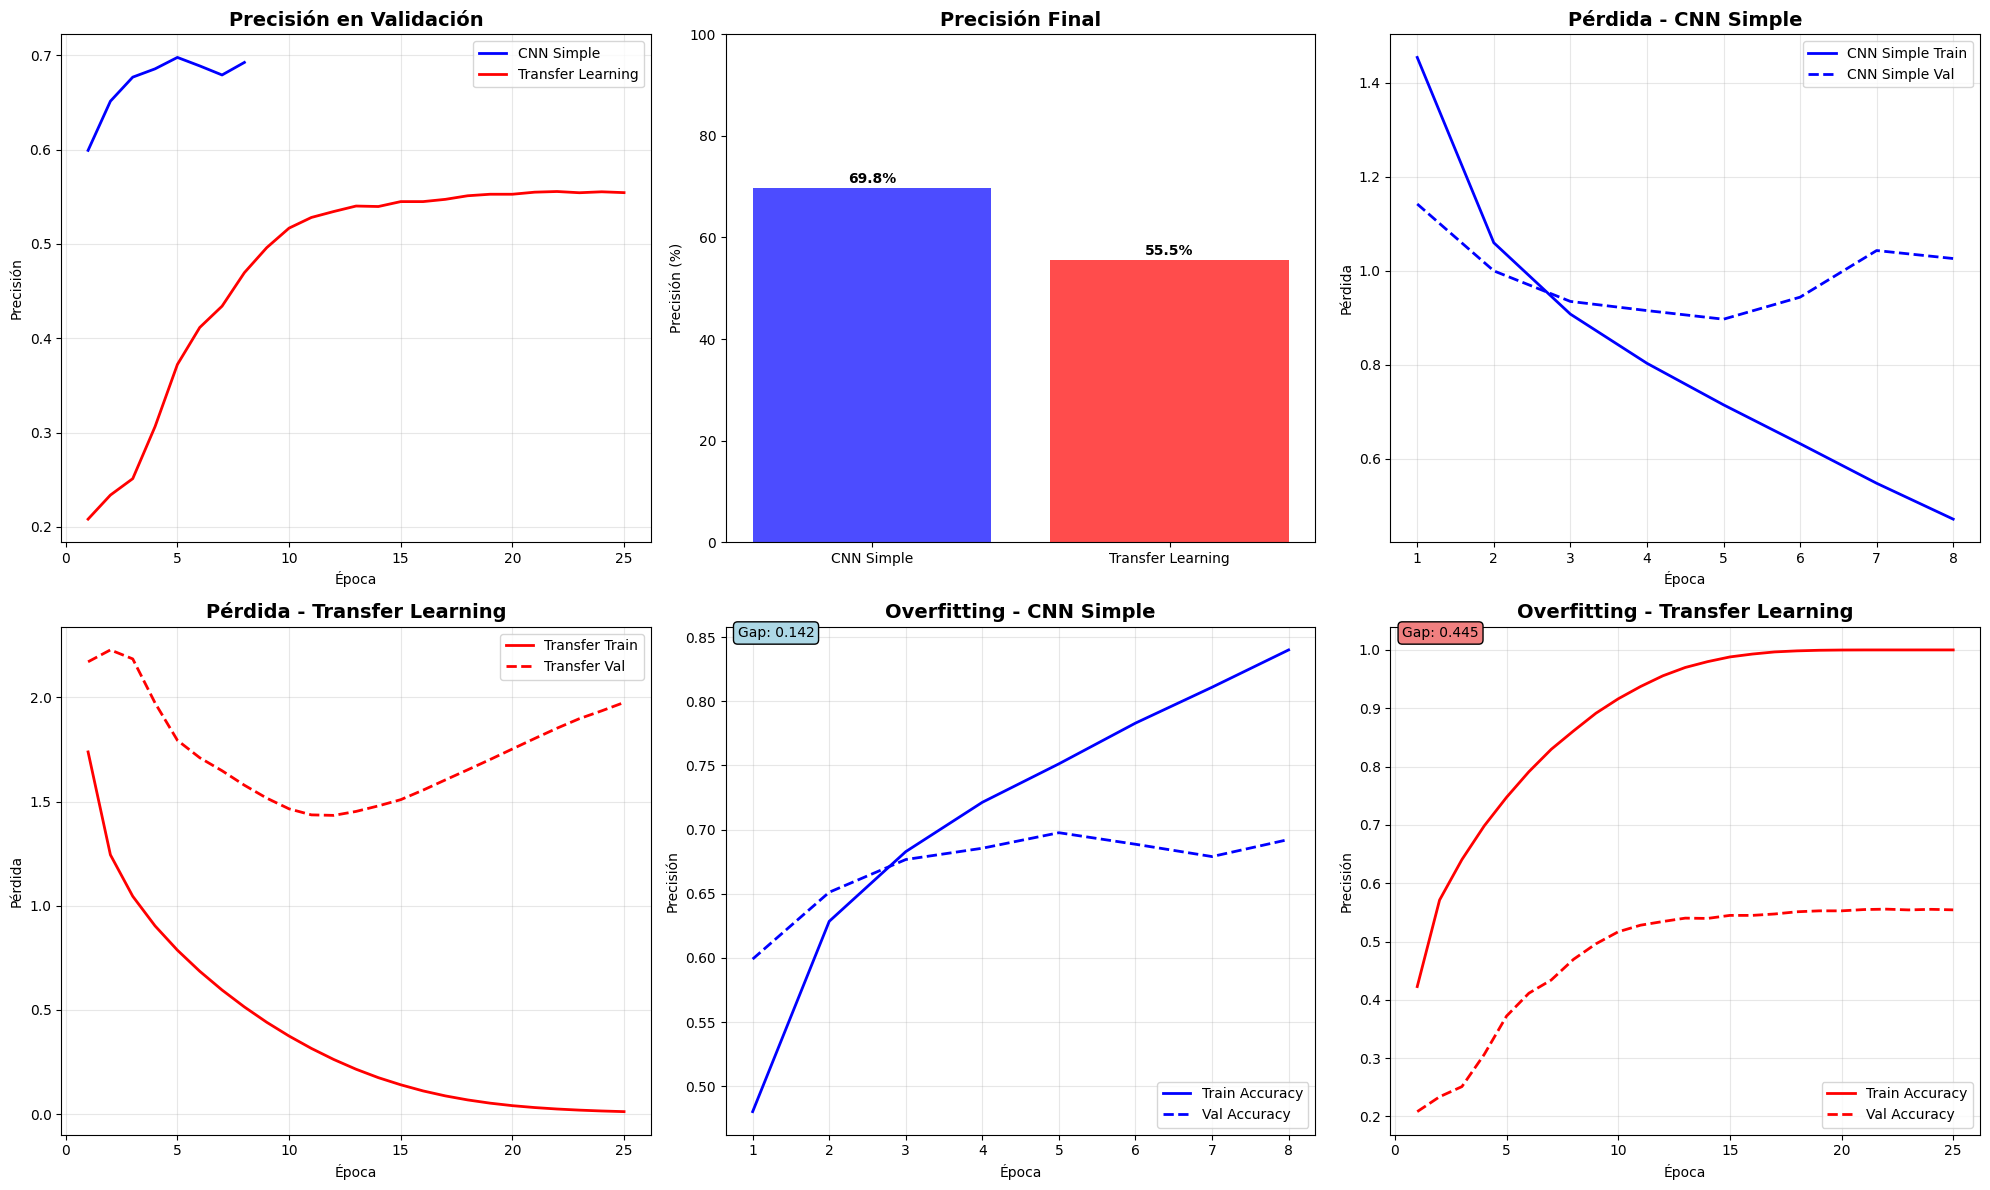


🔍 ANÁLISIS DE OVERFITTING:
🏗️ CNN Simple - Gap Train-Val: 0.142
🎯 Transfer Learning - Gap Train-Val: 0.445
⚠️ CNN Simple muestra overfitting significativo
⚠️ Transfer Learning muestra overfitting significativo

📋 REPORTE DE CLASIFICACIÓN - CNN SIMPLE:
              precision    recall  f1-score   support

    airplane       0.78      0.69      0.73      1000
  automobile       0.81      0.80      0.80      1000
        bird       0.61      0.58      0.59      1000
         cat       0.63      0.38      0.48      1000
        deer       0.55      0.79      0.65      1000
         dog       0.66      0.56      0.61      1000
        frog       0.82      0.74      0.78      1000
       horse       0.71      0.81      0.75      1000
        ship       0.66      0.90      0.76      1000
       truck       0.83      0.73      0.78      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.69     10000
weighted avg       0.71      0.70      0.69

In [12]:
# === EVALUACIÓN FINAL ===

print("📊 EVALUACIÓN FINAL")
print("-" * 50)

# Evaluar ambos modelos
simple_loss, simple_acc = simple_cnn.evaluate(x_test, y_test, verbose=0)
transfer_loss, transfer_acc = transfer_model.evaluate(x_test, y_test, verbose=0)

# Comparar resultados
print("📊 COMPARACIÓN FINAL:")
print(f"🏗️ CNN Simple: {simple_acc:.4f} ({simple_acc*100:.2f}%)")
print(f"🎯 Transfer Learning: {transfer_acc:.4f} ({transfer_acc*100:.2f}%)")
print(f"📈 Mejora: {(transfer_acc - simple_acc)*100:+.2f}%")

# Obtener predicciones para análisis detallado
simple_predictions = simple_cnn.predict(x_test)
transfer_predictions = transfer_model.predict(x_test)

# Convertir predicciones a clases
simple_pred_classes = np.argmax(simple_predictions, axis=1)
transfer_pred_classes = np.argmax(transfer_predictions, axis=1)
true_classes = np.argmax(y_test, axis=1)

# Graficar resultados con análisis de overfitting
plt.figure(figsize=(20, 12))

# Crear épocas específicas para cada métrica
simple_acc_epochs = range(1, len(simple_train_acc) + 1)
simple_loss_epochs = range(1, len(simple_history.history['loss']) + 1)
transfer_acc_epochs = range(1, len(transfer_train_acc) + 1)
transfer_loss_epochs = range(1, len(transfer_history.history['loss']) + 1)

# 1. Precisión en Validación
plt.subplot(2, 3, 1)
plt.plot(simple_acc_epochs, simple_test_acc, 'b-', label='CNN Simple', linewidth=2)
plt.plot(transfer_acc_epochs, transfer_test_acc, 'r-', label='Transfer Learning', linewidth=2)
plt.title('Precisión en Validación', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True, alpha=0.3)

# 2. Precisión Final (Bar Chart)
plt.subplot(2, 3, 2)
models = ['CNN Simple', 'Transfer Learning']
accuracies = [simple_acc*100, transfer_acc*100]
bars = plt.bar(models, accuracies, color=['blue', 'red'], alpha=0.7)
plt.title('Precisión Final', fontsize=14, fontweight='bold')
plt.ylabel('Precisión (%)')
plt.ylim(0, 100)

for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    plt.text(bar.get_x() + bar.get_width()/2, acc + 1, f'{acc:.1f}%',
             ha='center', fontweight='bold')

# 3. Pérdida durante Entrenamiento (CNN Simple)
plt.subplot(2, 3, 3)
plt.plot(simple_loss_epochs, simple_history.history['loss'], 'b-', label='CNN Simple Train', linewidth=2)
plt.plot(simple_loss_epochs, simple_history.history['val_loss'], 'b--', label='CNN Simple Val', linewidth=2)
plt.title('Pérdida - CNN Simple', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Pérdida durante Entrenamiento (Transfer Learning)
plt.subplot(2, 3, 4)
plt.plot(transfer_loss_epochs, transfer_history.history['loss'], 'r-', label='Transfer Train', linewidth=2)
plt.plot(transfer_loss_epochs, transfer_history.history['val_loss'], 'r--', label='Transfer Val', linewidth=2)
plt.title('Pérdida - Transfer Learning', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)

# 5. Análisis de Overfitting - CNN Simple
plt.subplot(2, 3, 5)
train_acc = simple_history.history['accuracy']
val_acc = simple_history.history['val_accuracy']
plt.plot(simple_acc_epochs, train_acc, 'b-', label='Train Accuracy', linewidth=2)
plt.plot(simple_acc_epochs, val_acc, 'b--', label='Val Accuracy', linewidth=2)
plt.title('Overfitting - CNN Simple', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True, alpha=0.3)

# Calcular gap de overfitting
overfitting_gap_simple = max(train_acc) - max(val_acc)
plt.text(0.02, 0.98, f'Gap: {overfitting_gap_simple:.3f}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

# 6. Análisis de Overfitting - Transfer Learning
plt.subplot(2, 3, 6)
train_acc_tl = transfer_history.history['accuracy']
val_acc_tl = transfer_history.history['val_accuracy']
plt.plot(transfer_acc_epochs, train_acc_tl, 'r-', label='Train Accuracy', linewidth=2)
plt.plot(transfer_acc_epochs, val_acc_tl, 'r--', label='Val Accuracy', linewidth=2)
plt.title('Overfitting - Transfer Learning', fontsize=14, fontweight='bold')
plt.xlabel('Época')
plt.ylabel('Precisión')
plt.legend()
plt.grid(True, alpha=0.3)

# Calcular gap de overfitting
overfitting_gap_tl = max(train_acc_tl) - max(val_acc_tl)
plt.text(0.02, 0.98, f'Gap: {overfitting_gap_tl:.3f}',
         transform=plt.gca().transAxes, fontsize=10,
         bbox=dict(boxstyle="round,pad=0.3", facecolor="lightcoral"))

plt.tight_layout()
plt.show()

# Análisis de overfitting
print("\n🔍 ANÁLISIS DE OVERFITTING:")
print(f"🏗️ CNN Simple - Gap Train-Val: {overfitting_gap_simple:.3f}")
print(f"🎯 Transfer Learning - Gap Train-Val: {overfitting_gap_tl:.3f}")

if overfitting_gap_simple > 0.1:
    print("⚠️ CNN Simple muestra overfitting significativo")
if overfitting_gap_tl > 0.1:
    print("⚠️ Transfer Learning muestra overfitting significativo")

# Reporte de clasificación
print("\n📋 REPORTE DE CLASIFICACIÓN - CNN SIMPLE:")
print(classification_report(true_classes, simple_pred_classes, target_names=class_names))

print("\n📋 REPORTE DE CLASIFICACIÓN - TRANSFER LEARNING:")
print(classification_report(true_classes, transfer_pred_classes, target_names=class_names))

🔬 COMPARANDO DIFERENTES ARQUITECTURAS
--------------------------------------------------

🧪 Probando: ResNet50
✅ Preprocesamiento aplicado: rango [-123.68, 151.06]
📊 Parámetros totales: 24,114,826
🔓 Parámetros entrenables: 527,114
✅ Accuracy en entrenamiento: 0.6678
✅ Accuracy en validación: 0.6654
✅ Accuracy en test: 0.6601

🧪 Probando: ResNet101
✅ Preprocesamiento aplicado: rango [-123.68, 151.06]
📊 Parámetros totales: 43,185,290
🔓 Parámetros entrenables: 527,114
✅ Accuracy en entrenamiento: 0.6644
✅ Accuracy en validación: 0.6432
✅ Accuracy en test: 0.6541

🧪 Probando: ResNet152
✅ Preprocesamiento aplicado: rango [-123.68, 151.06]
📊 Parámetros totales: 58,898,058
🔓 Parámetros entrenables: 527,114
✅ Accuracy en entrenamiento: 0.6483
✅ Accuracy en validación: 0.6521
✅ Accuracy en test: 0.6477

🧪 Probando: VGG16
✅ Preprocesamiento aplicado: rango [-123.68, 151.06]
📊 Parámetros totales: 14,848,586
🔓 Parámetros entrenables: 133,898
✅ Accuracy en entrenamiento: 0.6234
✅ Accuracy en valida

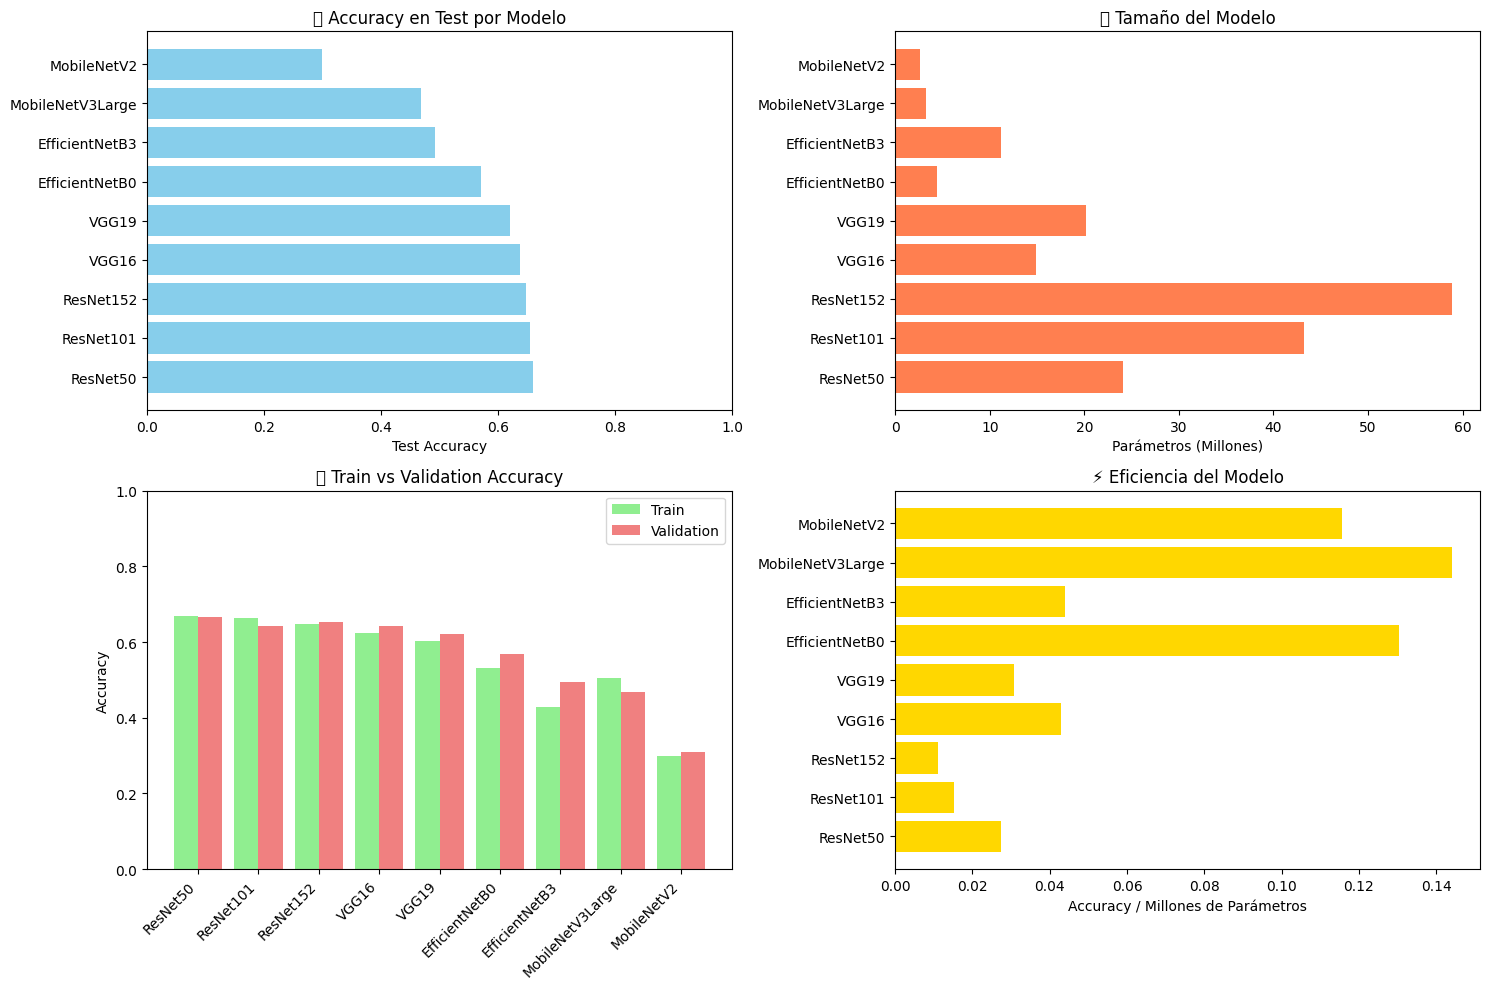


🏆 MEJOR MODELO: ResNet50
   ✅ Test Accuracy: 0.6601
   🔢 Parámetros: 24,114,826


In [13]:
# === COMPARACIÓN DE MODELOS DE TRANSFER LEARNING ===

print("🔬 COMPARANDO DIFERENTES ARQUITECTURAS")
print("-" * 50)

# Modelos a probar
models_to_test = {
    'ResNet50': applications.ResNet50,
    'ResNet101': applications.ResNet101,
    'ResNet152': applications.ResNet152,
    'VGG16': applications.VGG16,
    'VGG19': applications.VGG19,
    'EfficientNetB0': applications.EfficientNetB0,
    'EfficientNetB3': applications.EfficientNetB3,
    'MobileNetV2': applications.MobileNetV2,
    'MobileNetV3Large': applications.MobileNetV3Large
}

# Función para crear modelo con cualquier arquitectura
def create_transfer_model_generic(base_model_class, input_shape=(32, 32, 3), num_classes=10):
    base_model = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),  # Mejor que Flatten para transfer learning
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# === MEJORA CRÍTICA: Función de preprocesamiento por modelo ===
def get_preprocess_function(model_name):
    """
    Retorna la función de preprocesamiento específica para cada arquitectura.
    ESTO ES MUY IMPORTANTE para transfer learning!
    """
    preprocess_map = {
        'ResNet50': applications.resnet50.preprocess_input,
        'ResNet101': applications.resnet.preprocess_input,
        'ResNet152': applications.resnet.preprocess_input,
        'VGG16': applications.vgg16.preprocess_input,
        'VGG19': applications.vgg19.preprocess_input,
        'EfficientNetB0': applications.efficientnet.preprocess_input,
        'EfficientNetB3': applications.efficientnet.preprocess_input,
        'MobileNetV2': applications.mobilenet_v2.preprocess_input,
        'MobileNetV3Large': applications.mobilenet_v3.preprocess_input
    }
    return preprocess_map.get(model_name)

# Función para evaluar un modelo CON preprocesamiento correcto
def evaluate_model(model_name, model_class, x_train_raw, y_train, x_test_raw, y_test, epochs=5):
    print(f"\n{'='*60}")
    print(f"🧪 Probando: {model_name}")
    print(f"{'='*60}")

    try:
        # ⚠️ PASO CRÍTICO: Aplicar preprocesamiento específico del modelo
        preprocess_fn = get_preprocess_function(model_name)
        if preprocess_fn is not None:
            x_train_processed = preprocess_fn(x_train_raw.copy().astype('float32'))
            x_test_processed = preprocess_fn(x_test_raw.copy().astype('float32'))
            print(f"✅ Preprocesamiento aplicado: rango [{x_train_processed.min():.2f}, {x_train_processed.max():.2f}]")
        else:
            x_train_processed = x_train_raw / 255.0
            x_test_processed = x_test_raw / 255.0
            print(f"⚠️ Usando normalización estándar [0, 1]")

        # Crear modelo
        model = create_transfer_model_generic(model_class)

        # Compilar
        model.compile(
            optimizer=optimizers.Adam(learning_rate=0.001),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )

        # Contar parámetros
        total_params = model.count_params()
        trainable_params = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])

        print(f"📊 Parámetros totales: {total_params:,}")
        print(f"🔓 Parámetros entrenables: {trainable_params:,}")

        # Entrenar
        history = model.fit(
            x_train_processed, y_train,
            batch_size=128,
            epochs=epochs,
            validation_split=0.2,
            verbose=0
        )

        # Evaluar en test
        test_loss, test_acc = model.evaluate(x_test_processed, y_test, verbose=0)

        # Resultados
        results = {
            'model_name': model_name,
            'total_params': total_params,
            'trainable_params': trainable_params,
            'train_acc': history.history['accuracy'][-1],
            'val_acc': history.history['val_accuracy'][-1],
            'test_acc': test_acc,
            'test_loss': test_loss
        }

        print(f"✅ Accuracy en entrenamiento: {results['train_acc']:.4f}")
        print(f"✅ Accuracy en validación: {results['val_acc']:.4f}")
        print(f"✅ Accuracy en test: {results['test_acc']:.4f}")

        return results

    except Exception as e:
        print(f"❌ Error con {model_name}: {str(e)}")
        return None

# Ejecutar comparación
comparison_results = []

for model_name, model_class in models_to_test.items():
    result = evaluate_model(
        model_name,
        model_class,
        x_train_raw, y_train,  # ⚠️ CAMBIO: pasando datos RAW para preprocesar correctamente
        x_test_raw, y_test,    # ⚠️ CAMBIO: pasando datos RAW para preprocesar correctamente
        epochs=5  # Ajusta según tu tiempo disponible
    )
    if result:
        comparison_results.append(result)

# Crear DataFrame con resultados
import pandas as pd

results_df = pd.DataFrame(comparison_results)
results_df = results_df.sort_values('test_acc', ascending=False)

print("\n" + "="*80)
print("📊 RESUMEN DE COMPARACIÓN DE MODELOS")
print("="*80)
print(results_df.to_string(index=False))

# Visualizar resultados
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Accuracy en test
axes[0, 0].barh(results_df['model_name'], results_df['test_acc'], color='skyblue')
axes[0, 0].set_xlabel('Test Accuracy')
axes[0, 0].set_title('🎯 Accuracy en Test por Modelo')
axes[0, 0].set_xlim([0, 1])

# 2. Número de parámetros
axes[0, 1].barh(results_df['model_name'], results_df['total_params']/1e6, color='coral')
axes[0, 1].set_xlabel('Parámetros (Millones)')
axes[0, 1].set_title('🔢 Tamaño del Modelo')

# 3. Comparación train vs val accuracy
x_pos = range(len(results_df))
axes[1, 0].bar([p - 0.2 for p in x_pos], results_df['train_acc'],
               width=0.4, label='Train', color='lightgreen')
axes[1, 0].bar([p + 0.2 for p in x_pos], results_df['val_acc'],
               width=0.4, label='Validation', color='lightcoral')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels(results_df['model_name'], rotation=45, ha='right')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('📈 Train vs Validation Accuracy')
axes[1, 0].legend()
axes[1, 0].set_ylim([0, 1])

# 4. Eficiencia (accuracy / parámetros)
efficiency = results_df['test_acc'] / (results_df['total_params'] / 1e6)
axes[1, 1].barh(results_df['model_name'], efficiency, color='gold')
axes[1, 1].set_xlabel('Accuracy / Millones de Parámetros')
axes[1, 1].set_title('⚡ Eficiencia del Modelo')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Identificar el mejor modelo
best_model = results_df.iloc[0]
print(f"\n🏆 MEJOR MODELO: {best_model['model_name']}")
print(f"   ✅ Test Accuracy: {best_model['test_acc']:.4f}")
print(f"   🔢 Parámetros: {best_model['total_params']:,}")